# Fashion MNIST with GPU

## Table of Contents

In this project, you will learn how to use a GPU to speed up the training process. We will use convolutional neural networks on the Fashion-MNIST dataset to classify images of clothing.

* Preperation
* Getting the Data
* CNN Class Creation
* GPU Setup
* Training Preperation
* Training
* Results

## Preperation

In [ ]:
#!pip install torch
#!pip install torchvision

In [1]:
# PyTorch Modules you need for this lab

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
torch.manual_seed(0)

In [2]:
# Other non-PyTorch Modules

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

from PIL import Image

In [3]:
# Function to show images

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## Getting the Data

In this section, you will load a Dataset object, but first you must transform the dataset. Use the <code>Compose</code> function to perform the following transforms:

* use the transforms object <code> ToTensor </code> to convert the image to a tensor

In [4]:
composed = transforms.Compose([transforms.ToTensor()])

Create two dataset objects for the Fashion MNIST  dataset. One for training data called <code> dataset_train </code> and one for validation data <code> dataset_test </code>.

In [5]:
dataset_train = dsets.FashionMNIST(root= '.fashion/data', train=True, transform=composed,  download=True)
dataset_test = dsets.FashionMNIST(root= '.fashion/data', train=False, transform=composed,  download=True)

26422272it [00:34, 758215.02it/s]                              


Extracting .fashion/data\FashionMNIST\raw\train-images-idx3-ubyte.gz to .fashion/data\FashionMNIST\raw



29696it [00:00, 103105.18it/s]                          


Extracting .fashion/data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .fashion/data\FashionMNIST\raw



4422656it [00:05, 752749.44it/s]                             


Extracting .fashion/data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .fashion/data\FashionMNIST\raw



6144it [00:00, 6142980.64it/s]          
C:\Users\hp\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting .fashion/data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .fashion/data\FashionMNIST\raw

Processing...
Done!


Below you can see a few examples of the images we are working with

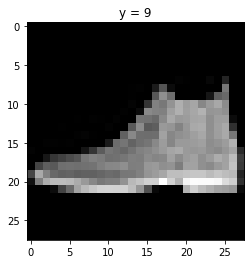

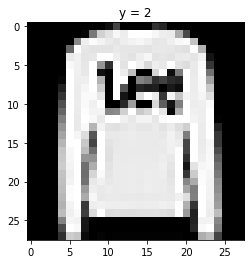

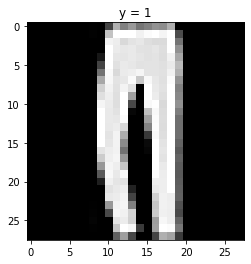

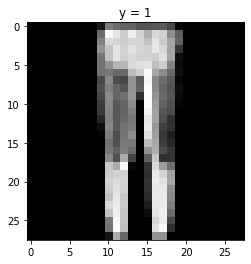

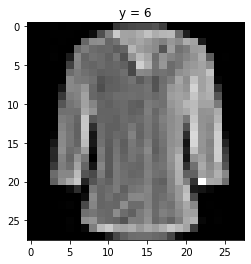

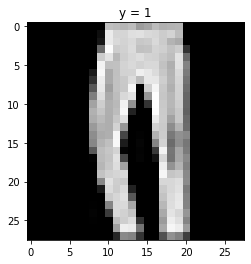

In [6]:
for n,data_sample in enumerate(dataset_test):
    show_data(data_sample)
    plt.show()
    if n==5:
        break 

Create a loader for the training data and testing data with batch size set to 100

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100 )
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=100 )

## CNN Class Creation

In [8]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_2 * 7 * 7, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

## GPU Setup

First lets see if there is a GPU available

In [9]:
torch.cuda.is_available()

True

If there is a GPU available then we will create our device object so we can use the GPU

In [10]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

## Training Preperation

First we will create our model and CNN object called model and send the model to the GPU

In [11]:
model = CNN()

model.to(device)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

Now we will create our loss function and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Training

Here we have defined a function that performs the training. It takes the model, criterion, optimizer, and number of epochs and trains the model using the GPU. It returns two lists that contain accuracy and cost values over the training process.

In [13]:
def train(model, criterion, optimizer, n_epochs):

    cost_list=[]
    accuracy_list=[]
    N_test=len(dataset_test)
    
    for epoch in range(n_epochs):

        cost=0
        model.train()

        for x, y in train_loader:
            
            # sends features and labels to the GPU
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost+=loss.item()

        correct=0
        model.eval()

        for x_test, y_test in test_loader:
            
            # sends the features and labels to the GPU
            x_test, y_test = x_test.to(device), y_test.to(device)
            
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()

        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        cost_list.append(cost)
    
    return cost_list, accuracy_list

Now we train the model and also track how long it takes

In [14]:
%%time

cost_list, accuracy_list = train(model, criterion, optimizer, n_epochs=5)

Wall time: 1min 15s


Training the model using the GPU took ~40 seconds. You can try to train the model without using the GPU by creating a new CNN object and commenting out all the code related to the device. Without the GPU the training took ~82 seconds which mean the GPU trains the CNN ~2 times faster than the CPU. Although 82 seconds is rather short if we increase the number of CNN nodes, layers, channels, etc. we can easily save massive amounts of time.

## Results

Now we can use the accuracy list and cost list to see how the model performed over the training process

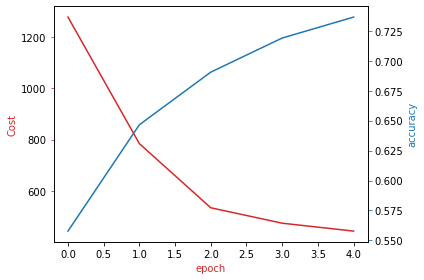

In [15]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()